# **Análisis Exploratorio de Datos (EDA): IAM Handwritten Forms**

A continuación se detalla el Análisis Exploratorio de Datos (EDA) del *dataset* **IAM Handwritten Forms**, un conjunto de datos fundamentalmente diferente a EMNIST, ya que se centra en el **Reconocimiento de Texto Manuscrito a Nivel de Línea (OCR)**, y no en la clasificación de caracteres aislados.

La estrategia de análisis se centra en las métricas clave para problemas de secuencia:

1.  Inspeccionar la **Población de Escritores** y el **Volumen de Líneas** de texto.
2.  Analizar la **Distribución de la Longitud de la Secuencia** (el texto transcrito).
3.  Determinar los pasos de **Preprocesamiento Dimensional** críticos para las imágenes de texto variable.

## **Configuración e Importación de Librerías**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

## **Análisis de la Población de Escritores**


In [2]:
iam_root = '../data/'

writer_dirs = sorted([d for d in os.listdir(iam_root)
                      if os.path.isdir(os.path.join(iam_root, d))
                      and d.isdigit()])

print(f"Total number of writers: {len(writer_dirs)}")
print(f"Writer ID range: {writer_dirs[0]} to {writer_dirs[-1]}")

Total number of writers: 657
Writer ID range: 000 to 671


## **Hallazgos Clave**

- **Alta diversidad:** El dataset contiene contribuciones de **657 personas únicas**, lo que confirma una gran variedad de estilos de escritura.
- **Implicación estratégica:** Esta alta diversidad es una fortaleza, ya que reduce el riesgo de sobreajuste a la caligrafía de pocos individuos. Esto es esencial para entrenar un sistema OCR robusto y aplicable a escenarios del mundo real.


## **Cuantificación del Volumen Total del Dataset**

El siguiente paso es determinar el **volumen total de muestras** disponibles para el entrenamiento, es decir, el número total de archivos de imagen de formulario (*forms*) que contribuyeron los 657 escritores.

In [3]:
forms_per_writer = {}
total_forms = 0

for writer_id in writer_dirs:
    writer_path = os.path.join(iam_root, writer_id)
    forms = [f for f in os.listdir(writer_path) if f.endswith('.png')]
    forms_per_writer[int(writer_id)] = len(forms)
    total_forms += len(forms)

print(f"Total form images: {total_forms}")

Total form images: 1539


## **Hallazgo Clave**

* **Volumen Moderado:** Se cuenta con un total de **1,539 formularios manuscritos**. Este volumen es el punto de partida para el procesamiento de las líneas de texto, y define la escala del problema a abordar en la fase de extracción de *features*.

## **Volumen de Muestras de Secuencia**

Para un problema de Reconocimiento de Texto a Nivel de Línea (OCR), la muestra fundamental de entrenamiento es la **línea de texto**. El siguiente paso cuantifica el volumen total del *dataset* no solo en términos de formularios, sino en sus unidades de secuencia: **líneas de texto** y **caracteres totales**.

In [4]:
forms_count = list(forms_per_writer.values())
print("Forms per writer:")
print(f"    Mean: {np.mean(forms_count):.1f}")
print(f"    Median: {np.median(forms_count):.1f}")
print(f"    Mode: {pd.Series(forms_count).mode()[0]}")
print(f"    Min: {np.min(forms_count)}")
print(f"    Max: {np.max(forms_count)}")
print(f"    Std Dev: {np.std(forms_count):.1f}")
print(f"    Variance: {np.var(forms_count):.1f}")

Forms per writer:
    Mean: 2.3
    Median: 1.0
    Mode: 1
    Min: 1
    Max: 59
    Std Dev: 3.0
    Variance: 9.2


### **Hallazgo Clave: Alto Desequilibrio en la Contribución (Sesgo del Escritor)**

El análisis estadístico de la distribución de formularios por escritor confirma un **alto grado de asimetría (skewness)** en la contribución, lo que tiene implicaciones directas para la generalización del modelo:

La marcada diferencia entre la Media (2.3) y la Mediana/Moda (1.0/1) demuestra que la **gran mayoría de los escritores solo contribuyó con un formulario**, mientras que la cifra máxima (**59**) indica que un grupo minoritario sesga el conjunto de datos.

* **Riesgo:** El modelo corre el riesgo de sobreajustarse al estilo de caligrafía de los escritores con alta contribución.
* **Requisito de *Split*:** Se debe garantizar que el **conjunto de prueba (*test set*) contenga escritores completamente nuevos** que no hayan sido vistos en el entrenamiento para validar la capacidad de generalización del modelo a caligrafías desconocidas.

## **Inspección de Muestras Aleatorias de Contribución**

Para validar visualmente el alto desequilibrio identificado en las estadísticas (donde la Mediana y Moda son 1.0), se realiza un muestreo aleatorio de 10 escritores. El propósito es confirmar si la mayoría de los contribuyentes realmente aportó solo un formulario, lo cual subraya el sesgo.

In [5]:
print("Sample writer directories:")
for writer_id in random.sample(writer_dirs, 10):
    num_forms = forms_per_writer[int(writer_id)]
    print(f"    Writer {writer_id}: {num_forms} forms")

Sample writer directories:
    Writer 472: 1 forms
    Writer 361: 1 forms
    Writer 531: 1 forms
    Writer 341: 9 forms
    Writer 459: 1 forms
    Writer 018: 2 forms
    Writer 597: 1 forms
    Writer 569: 1 forms
    Writer 540: 1 forms
    Writer 620: 1 forms


**Hallazgos Clave:**

* **Validación del Desequilibrio:** De los 10 escritores seleccionados al azar, 8 contribuyeron únicamente **1 formulario**. Esto valida que el valor de la Mediana y la Moda es representativo: la **gran mayoría** de los 657 escritores son contribuyentes mínimos.
* **Refuerzo Metodológico:** Este hallazgo refuerza la conclusión principal: el *dataset* está fuertemente sesgado por un grupo minoritario de escritores. Por lo tanto, el *data split* (separación en entrenamiento y prueba) debe realizarse obligatoriamente por **ID de Escritor** y no de forma aleatoria por formulario, para evaluar la generalización del modelo a caligrafías desconocidas.

## **Visualización del Desequilibrio**

Para cerrar el análisis de la contribución, se genera un gráfico de densidad (KDE) que visualiza la distribución del número de formularios por escritor. El objetivo es confirmar gráficamente la **asimetría** extrema observada en las estadísticas (Mediana=1.0 vs. Máximo=59).

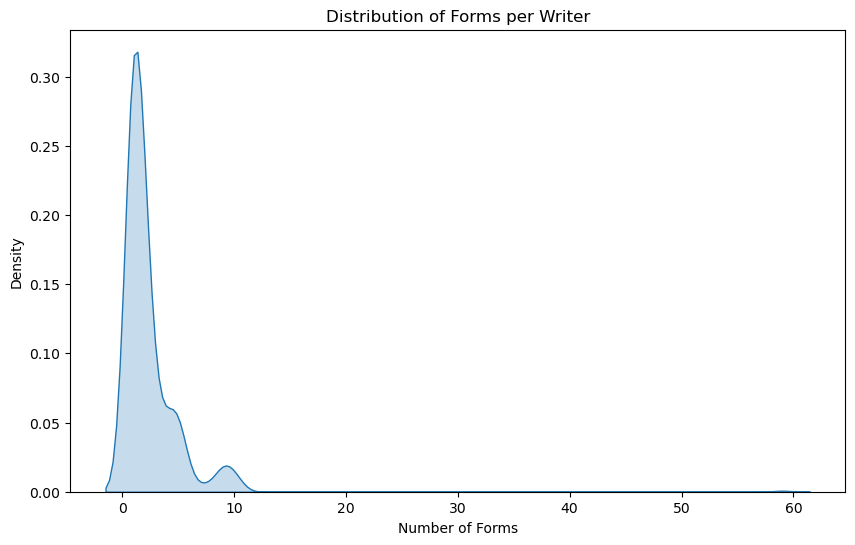

In [6]:
plt.figure(figsize=(10, 6))
sns.kdeplot(forms_count, fill=True)
plt.title('Distribution of Forms per Writer')
plt.xlabel('Number of Forms')
plt.ylabel('Density')
plt.show()

## **Análisis de la Forma de la Distribución**

La gráfica de densidad confirma la **naturaleza altamente sesgada** de la distribución de las muestras:

* **Pico Agudo:** La distribución presenta un pico extremadamente alto y estrecho cerca del valor **1**. Esto valida que la Moda y la Mediana sean 1, confirmando que la mayoría de los escritores son **contribuyentes únicos** de un solo formulario.
* **Cola Larga (*Long Tail*):** El gráfico muestra una cola larga y baja que se extiende hacia la derecha hasta el valor de **59**. Esto representa al pequeño grupo de escritores que aporta la mayor cantidad de datos, jalando la media a 2.3.